# Pre-processing

In [69]:
#Import Libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
#show all columns
pd.set_option('display.max_columns', 100)

### - Train/Test Beneficiary

In [71]:
#Load Training/Test datasets
bene_train_df = pd.read_csv('Train_Beneficiarydata-1542865627584.csv')
bene_test_df = pd.read_csv('Test_Beneficiarydata-1542969243754.csv')

In [72]:
print(bene_train_df.shape) # number of rows and columns
print(bene_test_df.shape)  

(138556, 25)
(63968, 25)


In [73]:
bene_df = pd.concat([bene_train_df, bene_test_df], axis=0)

In [74]:
#convert DOD dates to 1 (dead) and missing values to 0 (alive)
bene_df['DOD'] = bene_df['DOD'].fillna(0)
bene_df['DOD'] = bene_df['DOD'].str.contains('2009') == 1

In [75]:
bene_df['DOD'] = bene_df['DOD'].map({False:0, True:1})
bene_df['DOD'].value_counts()

0    200529
1      1995
Name: DOD, dtype: int64

In [76]:
#Convert age of patient to datetime 
bene_df['DOB'] = pd.to_datetime(bene_df['DOB'], format='%Y/%m/%d')

In [77]:
#convert currency into float
bene_df['IPAnnualReimbursementAmt'] = bene_df['IPAnnualReimbursementAmt'].astype(float)
bene_df['IPAnnualDeductibleAmt'] = bene_df['IPAnnualDeductibleAmt'].astype(float)
bene_df['OPAnnualReimbursementAmt'] = bene_df['OPAnnualReimbursementAmt'].astype(float)
bene_df['OPAnnualDeductibleAmt'] = bene_df['OPAnnualDeductibleAmt'].astype(float)

### - Train/Test Fraud Label

In [78]:
# load training/testing labels
label_train_df = pd.read_csv('Train-1542865627584.csv')
label_test_df = pd.read_csv('Test-1542969243754.csv')

In [79]:
label_train_df['PotentialFraud'] = label_train_df['PotentialFraud'].map({'No': 0, 'Yes': 1})

### - Train/Test Inpatient and Outpatient Data

In [80]:
#import inpatient/outpatient datasets
ip_train_df = pd.read_csv('Train_Inpatientdata-1542865627584.csv',na_values=[''])
ip_test_df = pd.read_csv('Test_Inpatientdata-1542969243754.csv',na_values=[''])

op_train_df = pd.read_csv('Train_Outpatientdata-1542865627584.csv',na_values=[''])
op_test_df = pd.read_csv('Test_Outpatientdata-1542969243754.csv',na_values=[''])

In [81]:
# combine inpatient test and train sets 
ip_df = pd.concat([ip_train_df,ip_test_df], axis=0).reset_index(drop = True)

# replace NAs in deductible amount with 0
ip_df.loc[:,'DeductibleAmtPaid'].fillna(0, inplace = True)

# replace NAs in the remaining columns with 'None'
ip_df.fillna('None', inplace = True)

# change data types of the data frame
ip_df = ip_df.astype(str)
ip_df.DeductibleAmtPaid=ip_df.DeductibleAmtPaid.astype(float)
ip_df.InscClaimAmtReimbursed=ip_df.InscClaimAmtReimbursed.astype(float)

# change date strings to datetime type
from datetime import date
ip_df['AdmissionDt'] = ip_df['AdmissionDt'].map(lambda x: date.fromisoformat(x))
ip_df['DischargeDt'] = ip_df['DischargeDt'].map(lambda x: date.fromisoformat(x))
ip_df['ClaimStartDt'] = ip_df['ClaimStartDt'].map(lambda x: date.fromisoformat(x))
ip_df['ClaimEndDt'] = ip_df['ClaimEndDt'].map(lambda x: date.fromisoformat(x))

# calculate time duration
ip_df['HospitalDuration'] = ip_df['DischargeDt'] - ip_df['AdmissionDt']
ip_df['ClaimDuration'] = ip_df['ClaimEndDt'] - ip_df['ClaimStartDt']

# convert durations to integers
ip_df['HospitalDuration'] = ip_df['HospitalDuration'].map(lambda x: x.days)
ip_df['ClaimDuration'] = ip_df['ClaimDuration'].map(lambda x: x.days) 

In [82]:
# Combine outpatient test and train set
op_df = pd.concat((op_train_df, op_test_df)).reset_index(drop=True)

# Imputing NA values with None (should only be None)
op_df.fillna('None', inplace = True)

# Convert dates into datetime
from datetime import datetime
op_df = op_df.astype(str)
op_df['ClaimStartDt'] = [datetime.strptime(date, '%Y-%m-%d') for date in op_df.ClaimStartDt]
op_df['ClaimEndDt'] = [datetime.strptime(date, '%Y-%m-%d') for date in op_df.ClaimEndDt]
op_df['Claimduration'] = op_df['ClaimEndDt'] - op_df['ClaimStartDt']
op_df['Claimduration'] = op_df['Claimduration'].map(lambda x: x.days)

# Make a column called month for the month of claim
op_df['ClaimMonth'] = op_df['ClaimStartDt'].map(lambda x: x.month)

# Change Dollar amount to float type
op_df['InscClaimAmtReimbursed'] = op_df['InscClaimAmtReimbursed'].astype(float)
op_df['DeductibleAmtPaid'] = op_df['DeductibleAmtPaid'].astype(float)

In [83]:
# create column indicating patient type
ip_df['PatientType'] = np.repeat('Inpatient', len(ip_df))
op_df['PatientType'] = np.repeat('Outpatient', len(op_df))

# combine all datasets
ip_op_df = pd.concat((ip_df, op_df), axis=0)
full_df = pd.merge(ip_op_df, bene_df, on = 'BeneID', how = 'left')
full_df  = pd.merge(full_df, label_train_df, how = 'inner', on = 'Provider')

## Warmup Question 1:
#### - How many medical doctors are there in the train outpatient dataset? How many medical doctors are there in the train inpatient dataset? Do they match with those from the outpatient record?

In [84]:
print(op_train_df['AttendingPhysician'].unique().shape[0]) 
print(ip_train_df['AttendingPhysician'].unique().shape[0]) 


74110
11605


- There are 62,505 more physicians for outpatients compared to inpatients 

#### - Do those inpatient patients show worse health conditions (in terms of chronic diseases) than typical outpatient patients?

In [85]:
# create new column with count of conditions
chron_patient = full_df.filter(regex='Chron').replace(to_replace=2, value=0).sum(axis=1).reset_index(name='Cond_Count')
condition = pd.concat([chron_patient, full_df[['BeneID', 'ClaimID', 'PatientType', 'PotentialFraud']]], axis=1)

condition.head()

,index,Cond_Count,BeneID,ClaimID,PatientType,PotentialFraud
0,0,7,BENE11001,CLM46614,Inpatient,1
1,1,7,BENE11001,CLM46614,Inpatient,1
2,2,5,BENE17521,CLM34721,Inpatient,1
3,3,2,BENE21718,CLM72336,Inpatient,1
4,4,6,BENE22934,CLM73394,Inpatient,1


Text(0, 0.5, 'Number of Chronic Conditions')

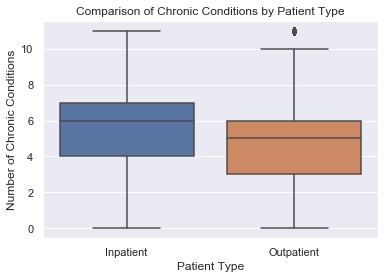

In [86]:
#boxplot of average conditions for type of patient
sns.boxplot(x='PatientType', y='Cond_Count', data=condition)
plt.title('Comparison of Chronic Conditions by Patient Type')
plt.xlabel('Patient Type')
plt.ylabel('Number of Chronic Conditions')

- Inpatients have a higher average number of chronic conditions compared to outpatient patients. 

#### - Do those who have more visits to the providers have worse health conditions? 

In [87]:
# create chronic conditions and claims counts
condition2 = pd.concat([chron_patient, full_df[['Provider', 'ClaimID']]], axis=1)
chronic = condition2.groupby(['Cond_Count'])['ClaimID'].count().reset_index(name='Claim_Count')

chronic.head()

,Cond_Count,Claim_Count
0,0,26575
1,1,53745
2,2,81276
3,3,101023
4,4,119901


Text(0, 0.5, 'Number of Claims')

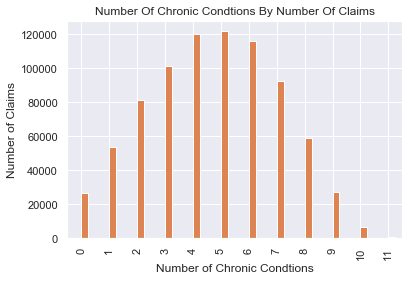

In [88]:
chronic.plot.bar(legend=None)
plt.title('Number Of Chronic Condtions By Number Of Claims')
plt.xlabel('Number of Chronic Condtions')
plt.ylabel('Number of Claims')

In [89]:
# create avg cond and acg claim columns
chronic2 = condition2.groupby(['Provider', 'Cond_Count'])['ClaimID'].count().reset_index(name='Claim_Count')\
           .groupby('Provider').agg({'Cond_Count': 'mean', 'Claim_Count': 'mean'}).reset_index()\
           .rename(columns={'Cond_Count':'Avg_Cond', 'Claim_Count': 'Avg_Claim'}) 

# merge labels
chronic3 = pd.merge(chronic2, label_train_df, on='Provider', how='left')
chronic3.head()

,Provider,Avg_Cond,Avg_Claim,PotentialFraud
0,PRV51001,5.888889,4.000000,0
1,PRV51003,5.000000,19.272727,1
2,PRV51004,4.500000,22.800000,0
3,PRV51005,4.500000,154.500000,1
4,PRV51007,4.000000,11.888889,0


Text(0, 0.5, 'Number of Avg Claims')

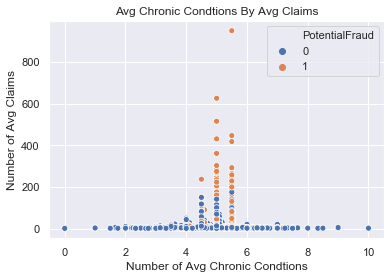

In [90]:
sns.scatterplot(x='Avg_Cond', y='Avg_Claim', data=chronic3, hue='PotentialFraud')
plt.title('Avg Chronic Condtions By Avg Claims')
plt.xlabel('Number of Avg Chronic Condtions')
plt.ylabel('Number of Avg Claims')

#### - How many medical doctors are there in the train inpatient dataset?  Do they match with those from the outpatient record?

In [91]:
print(op_train_df['BeneID'].unique().shape[0])
print(ip_train_df['BeneID'].unique().shape[0])

# 133980 distinct IDs for outpatients and 31289 distinct IDs for inpatients

133980
31289


#### - Do doctors serve for different providers? Study the distribution of hospital counts/doctor? Is it possible to characterize those doctors who move around among different providers?

In [95]:
#Provider count for each physicians

provider_count = pd.DataFrame(full_df.groupby('AttendingPhysician')['Provider']\
                    .agg('nunique')).sort_values(ascending = False, by = 'Provider').\
                    drop('None', axis = 0).reset_index()

provider_count = provider_count.groupby('Provider')['AttendingPhysician'].agg('count')
provider_count

Provider
1    76844
2     4741
3      382
4       65
5       19
6        9
7        1
8        1
9        1
Name: AttendingPhysician, dtype: int64

In [96]:
# create physician count column 
provider_count2 = full_df.groupby(['Provider', 'AttendingPhysician'])['AttendingPhysician'].count().\
                  reset_index(name='Phys_Count').groupby('Provider')['Phys_Count'].count().reset_index()

# merge label
provider_count2 = pd.merge(provider_count2, label_train_df, on='Provider', how='left')

(0, 200)

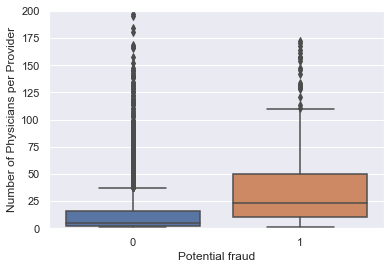

In [97]:
sns.boxplot(x='PotentialFraud', y='Phys_Count', data=provider_count2)
plt.xlabel('Potential fraud')
plt.ylabel('Number of Physicians per Provider')
plt.ylim([0,200])

 - Higher chance of potential fruad if a providers have many physicians compared to providers with less physicians

#### - Do patients go to different hospitals? Study the distribution of hospital counts/patient? It is possible to characterize those patients who receive services from a lot of different hospitals?

In [34]:
#patient count per provider
patient_count = full_df.groupby('BeneID')['Provider'].agg('nunique').sort_values(ascending = False).reset_index()
patient_count = patient_count.groupby('Provider')['BeneID'].agg('count')
patient_count.head()

Provider
1    46903
2    35118
3    23059
4    14232
5     8381
Name: BeneID, dtype: int64

In [103]:
# create column with provider count per patient
provider_patient = full_df.groupby(['BeneID', 'Provider', 'PotentialFraud'])['BeneID'].count().\
                   reset_index(name='Prov_Count').groupby(['BeneID', 'PotentialFraud'])['Prov_Count']\
                   .count().reset_index()

provider_patient.head()

,BeneID,PotentialFraud,Prov_Count
0,BENE100000,1,1
1,BENE100001,0,4
2,BENE100001,1,2
3,BENE100002,0,7
4,BENE100002,1,4


In [102]:
# create patient count column per provider 
Patients = full_df.groupby(['Provider', 'BeneID'])['BeneID'].count().reset_index(name='Patient_Count')\
           .groupby('Provider')['Patient_Count'].count().reset_index()

# merge label
pat_prov_count = pd.merge(Patients, label_train_df, on='Provider', how='left')

pat_prov_count.head()

,Provider,Patient_Count,PotentialFraud
0,PRV51001,24,0
1,PRV51003,117,1
2,PRV51004,138,0
3,PRV51005,495,1
4,PRV51007,58,0


Text(0, 0.5, 'Number of Patients Per Provider')

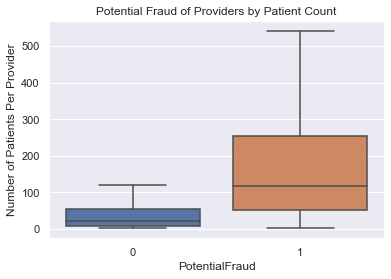

In [100]:
sns.boxplot(x='PotentialFraud', y='Patient_Count', data=pat_prov_count, showfliers=False)
plt.title('Potential Fraud of Providers by Patient Count')
plt.ylabel('Number of Patients Per Provider')

#### - Do the same providers provide both inpatient and outpatient services? Summarize your finding.

In [105]:
# groupy provider and patient type
prov_type = full_df.groupby(['Provider', 'PatientType'])['BeneID'].count().reset_index(name='').drop('', axis=1)
prov_type.head()

,Provider,PatientType
0,PRV51001,Inpatient
1,PRV51001,Outpatient
2,PRV51003,Inpatient
3,PRV51003,Outpatient
4,PRV51004,Outpatient


In [109]:
# create a dictionary provider by service type
lst_prov_type = list(zip(prov_type['Provider'], prov_type['PatientType']))

In [110]:
# feed in empty dict with values inpatient, outpatient, or both
prov_type_dict = {}

for i in lst_prov_type:
    if i[0] not in prov_type_dict:
        prov_type_dict[i[0]]= i[1]    
    else:
        prov_type_dict[i[0]] = 'Both'
        

# creaete new column type of service by provider
prov_service = pd.DataFrame(prov_type_dict.keys(), prov_type_dict.values()).reset_index().\
rename(columns={'index':'Service_Type', 0:'Provider'})

In [111]:
prov_service.head()

,Service_Type,Provider
0,Both,PRV51001
1,Both,PRV51003
2,Outpatient,PRV51004
3,Outpatient,PRV51005
4,Both,PRV51007


In [112]:
#number of providers by service types and potential fraud
service_type = pd.merge(prov_service, label_train_df, on='Provider')

print(service_type.groupby('Service_Type')['Provider'].count())

Service_Type
Both          1694
Inpatient      398
Outpatient    3318
Name: Provider, dtype: int64


## Potential Feature Engineering

In [50]:
# new df with physician count column
phys_count2 = full_df.groupby(['AttendingPhysician', 'Provider'])['AttendingPhysician'].count()\
              .reset_index(name='Phys_Count').groupby(['Provider'])['Phys_Count'].count().reset_index()

#train_features1 = pd.merge(label_train_df, phys_count2, on='Provider')

In [51]:
# add patient count column 
Patients = full_df.groupby(['Provider', 'BeneID'])['BeneID'].count().reset_index(name='Patient_Count')\
           .groupby('Provider')['Patient_Count'].count().reset_index()

train_features1 = pd.merge(phys_count2, Patients, on='Provider')

In [52]:
# add claim count column 
Claims = full_df.groupby(['Provider', 'ClaimID'])['ClaimID'].count().reset_index(name='Claim_Count').\
         groupby('Provider')['Claim_Count'].count().reset_index()

train_features2 = pd.merge(train_features1, Claims, on='Provider')

In [53]:
#number of providers by service types and potential fraud
service_type = pd.merge(prov_service, label_train_df, on='Provider')

In [54]:
#add type of service column 
train_features3 = pd.merge(train_features2, service_type, on='Provider')
train_features3.head()

,Provider,Phys_Count,Patient_Count,Claim_Count,Service_Type,PotentialFraud
0,PRV51001,14,24,25,Both,0
1,PRV51003,44,117,132,Both,1
2,PRV51004,38,138,149,Outpatient,0
3,PRV51005,7,495,1165,Outpatient,1
4,PRV51007,10,58,72,Both,0


Text(0, 0.5, 'Number of Patients')

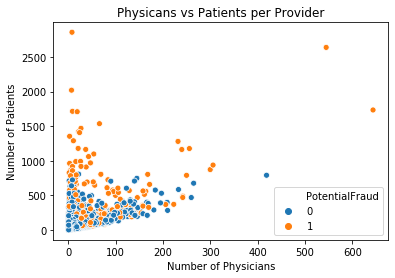

In [55]:
# graph of patients vs physicians by potential fraud

sns.scatterplot(x='Phys_Count', y='Patient_Count', data=train_features3, hue='PotentialFraud')
plt.title('Physicans vs Patients per Provider')
plt.xlabel('Number of Physicians')
plt.ylabel('Number of Patients')

### Warmup Question 2:
#### - Study the relationship between the patient ages (at the time of their service) and the counts of medical claims.

In [56]:
#Age of the patient at time ofservice
full_df['ClaimStartDt'] =  pd.to_datetime(full_df['ClaimStartDt'], format='%Y/%m/%d')
full_df['DOB'] =  pd.to_datetime(full_df['DOB'], format='%Y/%m/%d')
full_df['Age'] = full_df['ClaimStartDt'] - full_df['DOB']

In [57]:
#convert to years
full_df['Age'] = full_df['Age'] / np.timedelta64(1, 'Y')

#convert to int
full_df['Age'] = full_df['Age'].astype(int)

full_df['Age'].head()

0    66
1    66
2    95
3    87
4    79
Name: Age, dtype: int64

Text(0, 0.5, 'Number of Claims')

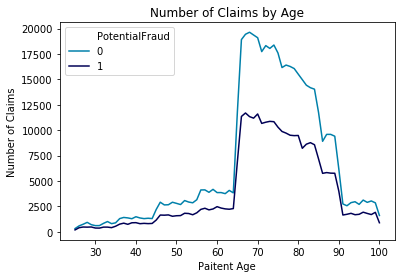

In [58]:
age_claim_count = full_df.groupby(['PotentialFraud', 'Age'])['ClaimID'].count().reset_index(name = 'Claim_Count') 

sns.lineplot(data = age_claim_count, x = 'Age', y = 'Claim_Count', hue = 'PotentialFraud', palette='ocean_r')
plt.title('Number of Claims by Age')
plt.xlabel('Paitent Age')
plt.ylabel('Number of Claims')

#### - Study the relationship between the patient age and their chronic conditions. Within the train-samples, do these chronic conditions show a definite trend with respect to increasing ages?

In [59]:
# df with condition count
chron_patient = full_df.filter(regex='Chron').replace(to_replace=2, value=0).sum(axis=1).reset_index\
                (name='Cond_Count').drop(chron_patient.columns[0], axis=1)

# concat additional columns
condition = pd.concat([chron_patient, full_df[['BeneID', 'ClaimID', 'PatientType', 'PotentialFraud', 'Age']]], axis=1)

condition.head()

,Cond_Count,BeneID,ClaimID,PatientType,PotentialFraud,Age
0,7,BENE11001,CLM46614,Inpatient,1,66
1,7,BENE11001,CLM46614,Inpatient,1,66
2,5,BENE17521,CLM34721,Inpatient,1,95
3,2,BENE21718,CLM72336,Inpatient,1,87
4,6,BENE22934,CLM73394,Inpatient,1,79


Text(0, 0.5, 'Condition Count')

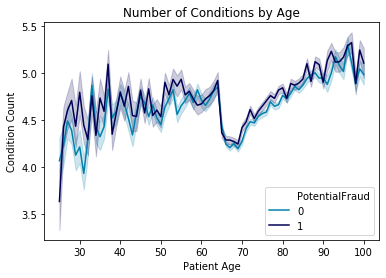

In [60]:
sns.lineplot(data = condition, x = 'Age', y = 'Cond_Count', hue = 'PotentialFraud', palette='ocean_r')
plt.title('Number of Conditions by Age')
plt.xlabel('Patient Age')
plt.ylabel('Condition Count')

 - There seems to be an increasing trend of potential fraud for patients with higher age and number of conditions

####  - In order to make sure the insurance premiums can cover the claims, the insurance company would need to categorize the patients according to their resource usage. In answering the question that what types of patients would make more outpatient visits, please provide your finding.

In [61]:
op = full_df.loc[full_df['PatientType'] == 'Outpatient']
ip = full_df.loc[full_df['PatientType'] == 'Inpatient']

In [62]:
# aggregate sum of outpatient chronic conditions
cond_sum_op = pd.DataFrame(op.agg({'ChronicCond_Alzheimer' : 'sum',
                   'ChronicCond_Heartfailure' : 'sum',
                   'ChronicCond_KidneyDisease' : 'sum',
                   'ChronicCond_Cancer' : 'sum',
                   'ChronicCond_ObstrPulmonary' : 'sum',
                   'ChronicCond_Depression' : 'sum',
                   'ChronicCond_Diabetes' : 'sum',
                   'ChronicCond_IschemicHeart' : 'sum',
                   'ChronicCond_Osteoporasis' : 'sum',
                   'ChronicCond_rheumatoidarthritis' : 'sum',
                   'ChronicCond_stroke' : 'sum'}))
                   #'RenalDiseaseIndicator' : 'sum'})

# aggregate sum of inpatient chronic conditions
cond_sum_ip = pd.DataFrame(ip.agg({'ChronicCond_Alzheimer' : 'sum',
                   'ChronicCond_Heartfailure' : 'sum',
                   'ChronicCond_KidneyDisease' : 'sum',
                   'ChronicCond_Cancer' : 'sum',
                   'ChronicCond_ObstrPulmonary' : 'sum',
                   'ChronicCond_Depression' : 'sum',
                   'ChronicCond_Diabetes' : 'sum',
                   'ChronicCond_IschemicHeart' : 'sum',
                   'ChronicCond_Osteoporasis' : 'sum',
                   'ChronicCond_rheumatoidarthritis' : 'sum',
                   'ChronicCond_stroke' : 'sum'}))    

In [63]:
#reset index and rename index to plot bar chart for outpatient and inpatient
cond_sum_op = cond_sum_op.rename(columns={cond_sum_op .columns[0]: "Count" }).reset_index()
cond_sum_op = cond_sum_op.rename(columns={cond_sum_op .columns[0]: "ChronicCond" })

cond_sum_ip = cond_sum_ip.rename(columns={cond_sum_ip.columns[0]: "Count" }).reset_index()
cond_sum_ip = cond_sum_ip.rename(columns={cond_sum_ip.columns[0]: "ChronicCond" })

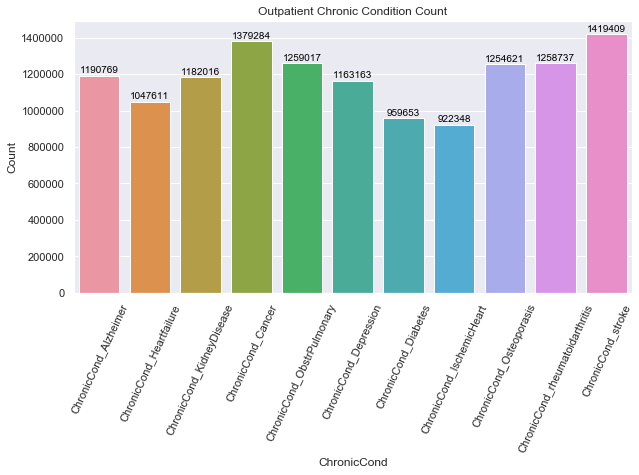

In [65]:
ax = sns.barplot(x='ChronicCond', y='Count', data=cond_sum_op)
ax.set_xticklabels(ax.get_xticklabels(), rotation=65)
sns.set(rc={'figure.figsize':(10,7)})
plt.title('Outpatient Chronic Condition Count')

for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
    textcoords='offset points')

#### - In answering what types of patients would make more inpatient service claims, please provide your findings.

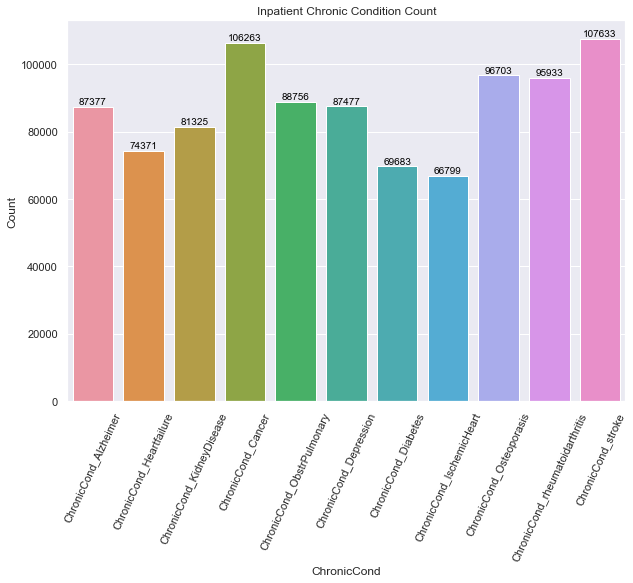

In [66]:
ax = sns.barplot(x='ChronicCond', y='Count', data=cond_sum_ip)
ax.set_xticklabels(ax.get_xticklabels(), rotation=65)
sns.set(rc={'figure.figsize':(10,7)})
plt.title('Inpatient Chronic Condition Count')

for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
    textcoords='offset points')

#### - From the prospect of the insurance company, the reimbursed amounts are their coverage on the claims.  Please analyze the patterns of the total reimbursed amounts (or average reimbursed amounts/visit) vs different types of patients.

#### - From the prospect of the providers, the sum of reimbursed amounts and deductibles are flowing to the providers. Based on this, analyze which types of patients contribute more to the providers in terms of the aggregate charges or the average charge per visit. 